In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

In [3]:
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.time import Time
from astropy import constants as const

# Novae
Prep the list of galactic novae... we'll need distances from Gaia

So far this looks like the best single-point source for Novae:
https://github.com/Bill-Gray/galnovae

In [4]:
from astropy.table import Table

In [5]:
# cleaned up table a little bit
tbl = Table.read('galnovae.txt', format='ascii.fixed_width_no_header', 
                 col_starts=(0, 14, 19, 22, 31, 44, 59, 73, 103, 110, 118, 140), 
                 names=('NOVA', 'YEAR', 'MM', 'DD', 'VARIABLE', 'RA', 'DEC', 
                        'mags', 'T3', 'CLASS', 'OBSCURE XID', 'DISCOVERER(S)'), 
                 data_start=1)

df = tbl.to_pandas()

/Users/james/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: TableReplaceWarning: converted column 'MM' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
# c_i = SkyCoord(ra_i, dec_i, distance=dd_i)
# df_out = pd.DataFrame(data={'RA':df['RA'], 'DEC':df['DEC']})
# df_out.to_csv('galnovae.csv')

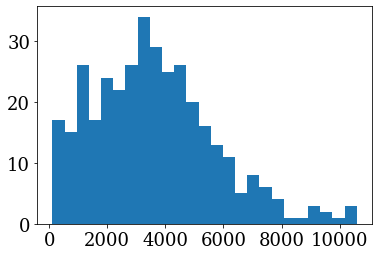

In [7]:
gdata0 = pd.read_csv('EDR3_xmatch_2arcsec.csv')
gdata = pd.read_csv('DR2BJ_xmatch_2arcsec.csv')
# gdata.columns
_ = plt.hist(gdata['rest'], bins=25)

In [8]:
mtch = np.zeros(len(df), dtype='int')-1
# i'm too lazy to figure out the pandas merge w/ this right now...
for k in range(len(df)):
    ok = gdata['col1'] == k
    if sum(ok) > 0:
        mtch[k] = np.where(ok)[0][0]
# mtch

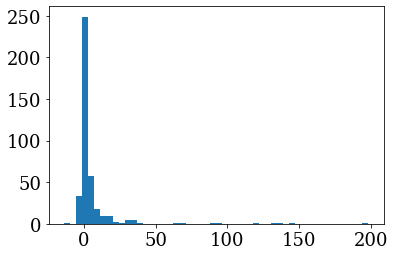

In [9]:
_ = plt.hist(gdata0['parallax_over_error'],bins=50)

In [10]:
# gdata['rest'][mtch[mtch > 0]]
# df['YEAR'][mtch > 0]
# gdata

In [11]:
aok = np.where(np.isfinite(df['YEAR']) & np.isfinite(df['MM']) &  np.isfinite(df['DD']) & 
               (df['MM'] <= 12) & (mtch > 0))[0]

In [12]:
tt = Time({'year': df['YEAR'].values[aok], 'month': df['MM'][aok].astype('int').values, 
           'day': df['DD'][aok].astype('int').values}, format='ymdhms')

cc = SkyCoord(ra=gdata['RA_ICRS'][mtch[aok]].values * u.deg, 
              dec=gdata['DE_ICRS'][mtch[aok]].values * u.deg, 
              distance=gdata['rest'][mtch[aok]].values * u.pc)

In [26]:
tt.byear

array([2020.75326079, 2020.68755097, 2020.53696596, 2020.36173976,
       2020.07973511, 2019.59786308, 2019.52667744, 2019.36240288,
       2018.78196612, 2018.42056209, 2018.32473527, 2018.2152189 ,
       2018.14950908, 2018.05094434, 2018.0372548 , 2017.78536714,
       2017.73060896, 2017.31444675, 2016.73127208, 2016.68472762,
       2016.4410537 , 2016.19190395, 2015.83049993, 2015.73741101,
       2015.23911153, 2015.15971216, 2015.11590561, 2015.1131677 ,
       2014.24525046, 2014.23156092, 2014.18227855, 2014.07002427,
       2013.91943926, 2013.89753599, 2013.82361244, 2013.61826924,
       2013.08985275, 2012.80237228, 2012.51489181, 2012.48477481,
       2012.35061725, 2012.25752834, 2012.23014925, 2012.22467343,
       2012.15348779, 2011.67982948, 2011.41425228, 2011.23355027,
       2010.30813694, 2010.13838657, 2010.03982183, 2009.90018846,
       2009.62365963, 2009.59628053, 2009.3498687 , 2009.30332424,
       2008.91180322, 2008.90358949, 2008.74205284, 2008.65170

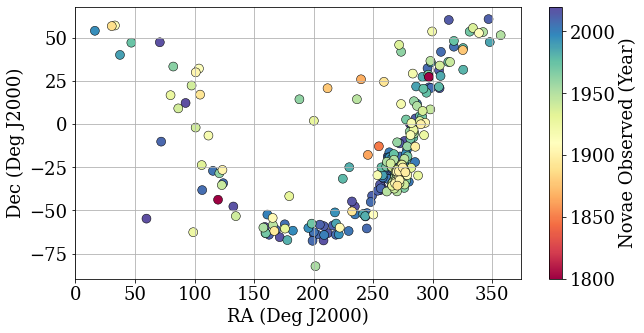

In [54]:
plt.figure(figsize=(10,5))
plt.scatter(cc.ra, cc.dec, c=tt.byear, 
            cmap=plt.cm.Spectral, edgecolors='k', lw=0.5, s=80)
plt.xlabel('RA (Deg J2000)')
plt.ylabel('Dec (Deg J2000)')
cb = plt.colorbar()
cb.set_label('Novae Observed (Year)')
plt.clim(1800,2020)
plt.grid(True)

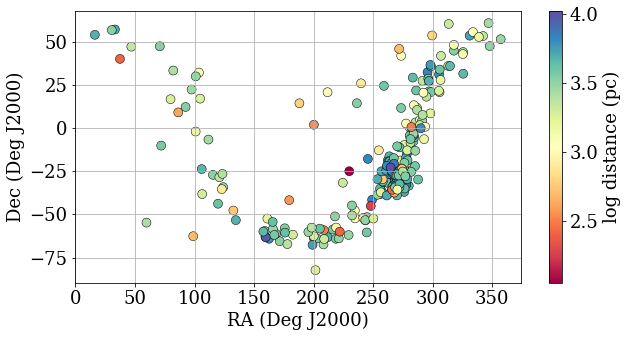

In [59]:
plt.figure(figsize=(10,5))
plt.scatter(cc.ra, cc.dec, c=np.log10(cc.distance.value), 
            cmap=plt.cm.Spectral, edgecolors='k', lw=0.5, s=80)
plt.xlabel('RA (Deg J2000)')
plt.ylabel('Dec (Deg J2000)')
cb = plt.colorbar()
cb.set_label('log distance (pc)')
# plt.clim(1800,2020)
plt.grid(True)

In [15]:
# plt.scatter(gdata['rest'][mtch[aok]].values, 
#             (gdata['B_rest'][mtch[aok]].values - 
#              gdata['b_rest'][mtch[aok]].values) / gdata['rest'][mtch[aok]].values/2)

# plt.yscale('log')